In [1]:
import torch
import torch.nn as nn
import torchvision

import os
import json
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

from datasets import CaptionDataset

%load_ext autoreload
%autoreload 2

# 01 JSON file

Before we may proceed to creating our custom dataset `CaptionDataset` we need to create:
- `word_map` - this is a traditional vocabulary where we basically enumerate tokens (in our case words from captions and some special tokens like `<start>`);
- a special `hdf5` file that keeps all our images;

To create these files we need `train/val/test` splits that we can find in so called `karpathy_json`. In the case of `flickr8k` we have just a single folder `images` without any splits. Let's have a look inside:
- we can read it into `dict` with keys `['images', 'dataset']`;
- `data['images']` contains list of dictionaries with information about images and related captions; its length is 8000 - this is the number of images in `flickr8k`; each of this dictionaries contains split, a few captions per image, filename and ids; we have already tokenized captiones so we don't have to do this manually;
- `data['dataset']` just contains the name of the dataset; in our case - `flickr8k`;

## `data` keys

In [2]:
JSON_DIR = '/Users/ilyarudyak/Library/Mobile Documents/com~apple~CloudDocs/datasets/caption_datasets'
karpathy_json_path = os.path.join(JSON_DIR, 'dataset_flickr8k.json')

In [3]:
with open(karpathy_json_path, 'r') as j:
    data = json.load(j)

In [4]:
type(data), data.keys()

(dict, dict_keys(['images', 'dataset']))

## `data['images']`

In [5]:
type(data['images']), len(data['images']), type(data['images'][0])

(list, 8000, dict)

In [6]:
data['images'][0].keys()

dict_keys(['sentids', 'imgid', 'sentences', 'split', 'filename'])

In [7]:
splits = set([data['images'][i]['split'] for i in range(len(data['images']))])

In [8]:
splits

{'test', 'train', 'val'}

In [9]:
len(data['images'][0]['sentences'][0]), data['images'][0]['sentences'][0].keys()

(4, dict_keys(['tokens', 'raw', 'imgid', 'sentid']))

In [10]:
data['images'][0]['sentences'][0]['raw']

'A black dog is running after a white dog in the snow .'

In [11]:
data['images'][0]['filename']

'2513260012_03d33305cf.jpg'

In [12]:
IMAGE_DIR = '/Users/ilyarudyak/Library/Mobile Documents/com~apple~CloudDocs/datasets/flickr8k/images'
image_file = os.path.join(IMAGE_DIR, data['images'][0]['filename'])

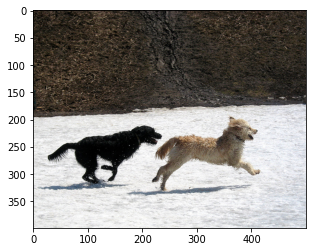

In [13]:
plt.imshow(Image.open(image_file));

## `data['dataset']`

In [14]:
type(data['dataset'])

str

In [15]:
data['dataset']

'flickr8k'

# 02 `word_map`

Creating the `word_map` is straightforward:
- iterate over `data['images']` (again these are dictionaries that contain all the information about images and corresponding captions);
- for each such dictionary extract tokenized captiones and feed them to the `Counter` object `word_freq`;
- using `word_freq` and `min_word_freq` (which is a hyperparameter) create `word_map`;
- add some special tokens like `start`; we reserve `index = 0` for `<pad>` token;

In [28]:
DATA_DIR = '/Users/ilyarudyak/Library/Mobile Documents/com~apple~CloudDocs/datasets/flickr8k/'
word_map_file = os.path.join(DATA_DIR, 'WORDMAP_flickr8k.json')

In [29]:
with open(word_map_file, 'r') as j:
    word_map = json.load(j)

In [32]:
type(word_map), len(word_map), list(word_map.items())[:3]

(dict, 2633, [('a', 1), ('black', 2), ('dog', 3)])

In [40]:
rev_word_map = {v: k for k, v in word_map.items()}

In [45]:
def _read_caption(caption, rev_word_map=rev_word_map, with_pad=False):
    if with_pad:
        conv_cap = [rev_word_map[int(i)] for i in caption]
    else:
        conv_cap = [rev_word_map[int(i)] for i in caption if i != 0]
    return ' '.join(conv_cap)

# 03 `hdf5` file

Instead of explaining of a (long) procedure to build this file lets just look inside. We may see that this file returns basically a dictionary that contains images. Images resized to `(256, 256)`. 

It also has an attribute `captions_per_image`. In COCO dataset some images can have more than 5 captions per image so we better use this limit (this mentioned in the paper).

In [16]:
DATA_DIR = '/Users/ilyarudyak/Library/Mobile Documents/com~apple~CloudDocs/datasets/flickr8k'
train_images_file = os.path.join(DATA_DIR, 'TEST_IMAGES_flickr8k.hdf5')

In [17]:
with h5py.File(train_images_file, 'r') as hdf:
    print(hdf.keys(), type(hdf['images']))
    images = np.array(hdf['images'])
    print(images.shape)

<KeysViewHDF5 ['images']> <class 'h5py._hl.dataset.Dataset'>
(1000, 3, 256, 256)


In [18]:
with h5py.File(train_images_file, 'r') as hdf:
    print(hdf.attrs.keys())
    print(hdf.attrs['captions_per_image'])

<KeysViewHDF5 ['captions_per_image']>
5


# 04 `CaptionDataset`

Lets create a train dataset and look at some of its parameters:
- we have 5 captions per image as we may expect (`ds.cpi = 5`);
- we store images in `ds.imgs` in the format of `hdf5` file and then convert them into tensor manually; we have 6K resized to `(256, 256)` images with channels first for `pytorch`;
- we have 30K captions (5 captions per image) of length 52; they use `<start>` and `<end>` indicies and padded with `<pad>` index; they are encoded into indicies using `word_map`;

In [19]:
ds = CaptionDataset()

In [23]:
ds.split, ds.cpi

('TRAIN', 5)

In [22]:
type(ds.imgs), ds.imgs.shape

(h5py._hl.dataset.Dataset, (6000, 3, 256, 256))

In [25]:
type(ds.captions), len(ds.captions)

(list, 30000)

In [27]:
set([len(c) for c in ds.captions])

{52}

In [26]:
print(ds.captions[0])

[2631, 1, 2, 3, 4, 5, 6, 1, 7, 3, 8, 9, 10, 2632, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Let's try to read the first 5 captions and plot the image.

In [47]:
for i in range(5):
    print(_read_caption(ds.captions[i]))

<start> a black dog is running after a white dog in the snow <end>
<start> two dogs chase each other across the snowy ground <end>
<start> two dogs running through a low lying body of water <end>
<start> black dog chasing brown dog through snow <end>
<start> two dogs play together in the snow <end>


In [50]:
np.array(ds.imgs[0]).shape, np.array(ds.imgs[0]).transpose(1, 2, 0).shape

((3, 256, 256), (256, 256, 3))

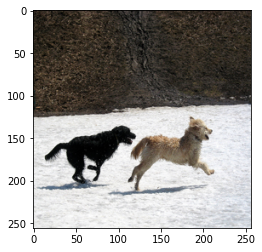

In [51]:
plt.imshow(np.array(ds.imgs[0]).transpose(1, 2, 0));